<a href="https://colab.research.google.com/github/GiuliaFContardi/FL_IDS-GAN/blob/main/preprocessingCSECICIDS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Collegamento a Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import dei Dataset csv dal Drive

In [ ]:
#Import delle librerie
#data preprocessing e cleansing steps
import pandas as pd

#### Thursday dataset

In [ ]:
# import dei csv del dataset CSE-CIC-IDS-2018 migliorato da ricercatori Liu et al.(2022) - https://intrusion-detection.distrinet-research.be/CNS2022/
#df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Thursday-15-02-2018.csv')
#df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Thursday-22-02-2018.csv')
#df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Thursday-01-03-2018.csv')

In [ ]:
#merge
clean_df = pd.concat([df1,df2,df3])

del df1
del df2
del df3

#### Friday dataset

In [ ]:
#df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Friday-02-03-2018.csv')
#df5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Friday-16-02-2018.csv')
#df6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Friday-23-02-2018.csv')

In [ ]:
#merge
#df = pd.concat([df4,df5,df6])

#del df4
#del df5
#del df6

#### Tuesday e Wednesday dataset

In [ ]:
df7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Tuesday-20-02-2018.csv')
df8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Wednesday-28-02-2018.csv')

#merge
clean_df2 = pd.concat([df7,df8])

del df7
del df8

In [ ]:
clean_df2.shape

(12623428, 91)

In [ ]:
#droppo benigni perché ne ho già abbastanza
clean_df2.drop(clean_df2.loc[clean_df2['Label']=='BENIGN'].index, inplace=True)

In [ ]:
clean_df2.loc[clean_df2["Attempted Category"] != -1, "Label"] = "BENIGN"
clean_df2.drop(clean_df2.loc[clean_df2['Label']=='BENIGN'].index, inplace=True)

In [ ]:
clean_df2.shape

(21591, 91)

#### Wednesday dataset

In [ ]:
##supera la RAM disponibile sebbene sia PRO a 51GB
df9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Wednesday-14-02-2018.csv')
df10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2018/Improved/Wednesday-21-02-2018.csv')


In [ ]:
#merge
clean_df = pd.concat([df9,df10])

del df9
del df10
#del df9

## Pre-processing: cleaning

In [ ]:
#clean_df['Label'].value_counts()
clean_df2['Label'].value_counts()

Infiltration - NMAP Portscan    21591
Name: Label, dtype: int64

## Primi aggiustamenti di pre-processing

In [ ]:
#come da avviso del paper si considerano Benign tutti gli "Attempted"
clean_df2.loc[clean_df2["Attempted Category"] != -1, "Label"] = "BENIGN"
clean_df2['Label'].value_counts()

Infiltration - NMAP Portscan    21591
Name: Label, dtype: int64

Si segue fonte Ali et al. (2023) per il preprocessing:



---




*   raccolgo attacchi




In [ ]:
#cancella attempted ed id colonna perché inutile
clean_df2 = clean_df2.drop('Attempted Category', axis=1)
clean_df2 = clean_df2.drop('id', axis=1)

#si raggruppa considerando la categoria di attacchi Ali et al. (2023) tabella 2 p.11
#unisco in DoS
clean_df2.loc[clean_df2["Label"] == 'Infiltration - NMAP Portscan', "Label"] = "Portscan"
##clean_df.loc[clean_df["Label"] == 'DDoS-LOIC-UDP', "Label"] = "DDoS"
#unisco Brute Force
#clean_df.loc[clean_df["Label"] == 'SSH-BruteForce', "Label"] = "BruteForce"



clean_df2['Label'].value_counts()

Portscan    21591
Name: Label, dtype: int64

In [ ]:
clean_df2.shape

(21591, 89)

In [ ]:
#Poblemi di generazione per la GAN: i label che hanno pochi dati daranno problemi nella creazione ... servono almeno 200-500 sample
#cit Kurniabudi, Stiawan et al. (2020)
#Si decide di droppare la categoria WebAttack per pochi elementi in quanto non si può unire ad altri
clean_df.drop(clean_df.loc[clean_df['Label']=='WebAttacks'].index, inplace=True)
clean_df.drop(clean_df.loc[clean_df['Label']=='BruteForce'].index, inplace=True)
clean_df['Label'].value_counts()

BENIGN          17961522
Infiltration       39834
DoS                31050
Name: Label, dtype: int64

In [ ]:
clean_df.shape #sono presenti moltissime feature... 89

#dataset2017 iniziale (2099774, 89)
#questo ==> (18032406, 89)

(12882534, 89)

In [ ]:
clean_df = pd.concat([clean_df,clean_df2])

(12882534, 89)

In [ ]:
clean_df['Label'].value_counts()

BENIGN        11682723
DDoS           1084023
BruteForce       94197
Portscan         21591
Name: Label, dtype: int64

In [ ]:
clean_df

# Feature engineering e pulizia del dataset

##Primi step

In [ ]:
#####Pulizia del dataset
#Import librerie per preprocessing e visualization
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

#re-indicizzo random in modo che non rimangano concatenati i dataset dei giorni per fare dopo lo splitting ed avere un minimo di uniformitàDistrib dei dati negli split
from sklearn.utils import shuffle
clean_df = shuffle(clean_df).reset_index()
clean_df = clean_df.drop("index", axis=1) #elimino colonna indice creata dal reset_index

Si segue fonte Ali et al. (2023) per il preprocessing:



---




* elimino IP, timestamp e flowID in quanto possono essere spoofati




In [ ]:
#elimino feature non utili
clean_df = clean_df.drop('Src IP', axis=1)
clean_df = clean_df.drop('Dst IP', axis=1)
clean_df = clean_df.drop('Timestamp', axis=1)
clean_df = clean_df.drop('Flow ID', axis=1)

In [ ]:
clean_df.shape # 89 ===> 85 feature

## Altre tecniche pre-processing

In [ ]:
#SALVO CSV Prima del pre-processing vero ...potesse servirmi per cambiare e fare altro
clean_df.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Preprocessed/dataNONpreprocessThurs.csv', index = False)

In [ ]:
#rinomino colonne togliendo spazi fastidiosi
clean_df.columns = clean_df.columns.str.replace(' ', '')

### Check NaN, 0...


In [ ]:
#CIT - https://www.kaggle.com/code/filipekoriginal/cicids2017-preprocessing/notebook#DETECTING-HIGHLY-CORRELATED-PAIRS

# searching for NA values - empty "" are not considered NA
pd.options.mode.use_inf_as_na = True ##infinito è trattato come NA
print(clean_df.loc[:, clean_df.isnull().any()].isnull().sum())
print("=====================")

### NA values are minority of the dataset. Because they cannot be processed by algorithms => cancello
clean_df = clean_df.dropna()
print(clean_df.shape)
print("=====================")

### tolgo feature ridondanti
describe_info = clean_df.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
clean_df.drop(columns=all_zeroes_cols, inplace=True)
print(all_zeroes_cols)
#[] output ==> non ci sono ridondanze

FlowBytes/s      5
FlowPackets/s    5
dtype: int64
(2099769, 85)
Empty DataFrame
Columns: []
Index: [count, mean, std, min, 25%, 50%, 75%, max]


In [ ]:
#droppo colonne di tutti 0
clean_df = clean_df.loc[:, (clean_df != 0).any(axis=0)]
clean_df.shape
#non ci sono

(2099769, 85)

In [ ]:
#droppo righe di tutti 0
clean_df[~(clean_df == 0).all(axis=1)]
clean_df.shape
#non ci sono

(2099769, 85)

In [ ]:
#doppio check INF as NA
with pd.option_context('mode.use_inf_as_na', True):
  clean_df.dropna(inplace=True)

#### Visualization

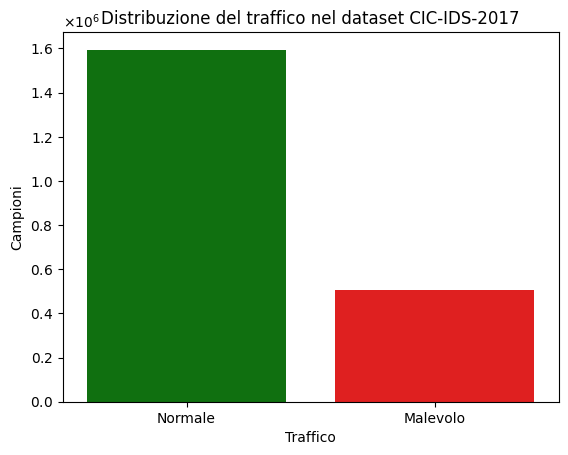

In [ ]:
## temporarily add new column to distinguish traffic type between Normal / Attack
df_plot = clean_df.copy()
trf_type = df_plot.loc[:, "Label"].map(lambda lbl: "Normale" if lbl == "BENIGN" else "Malevolo")
trf_type.name = "traffic type"
df_plot.loc[:, trf_type.name] = trf_type

### plot distrtibution of Normal traffic and Attacks in the whole dataset
plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter

sns.countplot(x="traffic type", data=df_plot, palette=["g","r"])
plt.title("Distribuzione del traffico nel dataset CIC-IDS-2017")
plt.xlabel("Traffico")
plt.ylabel("Campioni")
#salva in Drive
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
plt.savefig(f"{images_dir}/distributionCICIDS2017.pdf", dpi=200, format='pdf')
plt.show()

## Feature Extraction per importanza e correlazione

In [ ]:
df_importance = clean_df.copy()

## feature selection phase - let's use RFC on our data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=10, n_jobs=-1) # 100 trees in forest

## feature selection phase - prepare data for RFC
lbls = df_importance.loc[:, "Label"]
data_w_o_cat_attrs = df_importance.iloc[:, :-2]

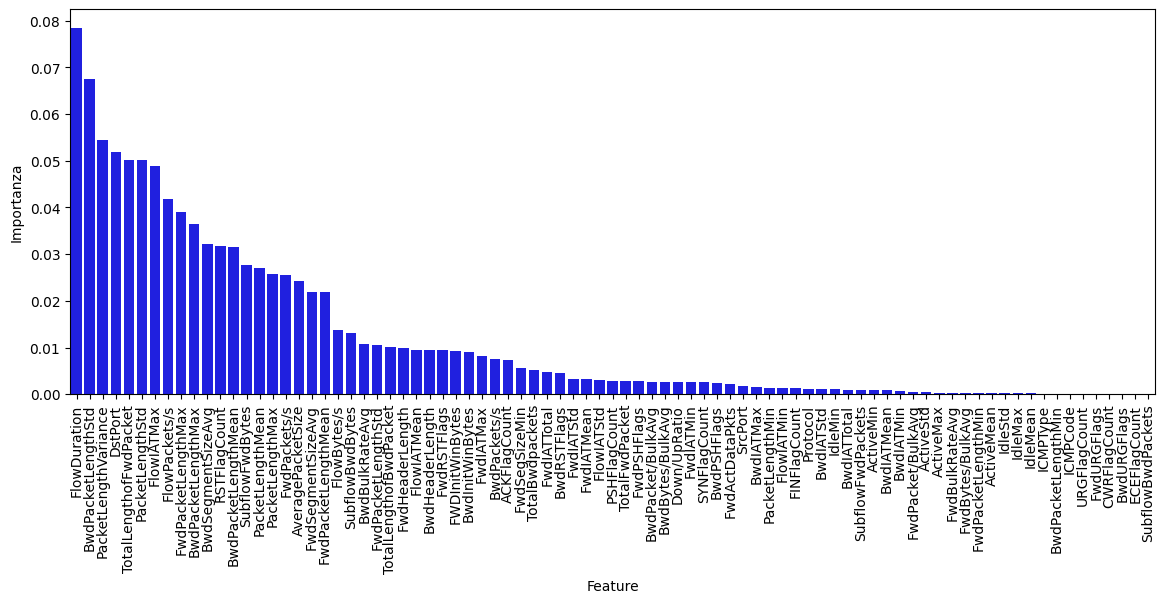

In [ ]:
# fit random forest classifier on the dataset
rfc.fit(data_w_o_cat_attrs, lbls)
RandomForestClassifier(n_jobs=-1, random_state=10)
## plotting features' importance in the whole dataset graph
# extract important features
score = np.round(rfc.feature_importances_,5)
importances = pd.DataFrame({'Feature':data_w_o_cat_attrs.columns,'Importanza':score})
importances = importances.sort_values('Importanza',ascending=False).set_index('Feature')

# plot importances
sns.barplot(x=importances.index, y="Importanza", data=importances, color="b")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
plt.savefig(f"{images_dir}/importanzaFeatureCICIDS2017.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [ ]:
## Let's leave only the most important features
threshold = 0.0002 # importance threshold - abbassato per non togliere troppe feature che verranno controllate poi con la varianza

bl_thresh = importances.loc[importances["Importanza"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))


there are 12 features to delete, as they are below chosen threshold
these features are the following:
IdleStd
IdleMax
IdleMean
ICMPType
BwdPacketLengthMin
ICMPCode
URGFlagCount
FwdURGFlags
CWRFlagCount
BwdURGFlags
ECEFlagCount
SubflowBwdPackets


In [ ]:
#Si toglie dall'array 1 feature ritenuta importanti nel paper Ali et al(2023)
feats_to_del.remove('BwdPacketLengthMin')
print(feats_to_del)

['IdleStd', 'IdleMax', 'IdleMean', 'ICMPType', 'ICMPCode', 'URGFlagCount', 'FwdURGFlags', 'CWRFlagCount', 'BwdURGFlags', 'ECEFlagCount', 'SubflowBwdPackets']


In [ ]:
## removing these not important features
df_importance.drop(columns=feats_to_del, inplace=True) #11 feature tolte per poca importanza

##### Varianza

In [ ]:
#controllo la varianza delle feature per poi eliminarle se hanno basso o quasi-0 varianza
pd.options.display.float_format = '{:,.20f}'.format
pd.set_option('display.max_rows', df_importance.shape[0]+1)
df_importance.var()


Feature con 0 varianza
```
FwdRSTFlags                                    0.75436721398006911787
BwdRSTFlags                                    0.16196824729130132603
FINFlagCount                                   0.95653599537860134472
RSTFlagCount                                   0.86335375735224939575
Down/UpRatio                                   0.06843146539131091111
* SubflowFwdPackets                              0.02553525700587332137
```

Feature eliminate dal paper di riferimento:BwdPSHFlags,
BwdURGFlags, FwdBulkRateAvg, FwdBytes, BulkAvg,
FwdPacket/BulkAvg, FwdURGFlags, **SubﬂowBwdPackets**,
and URGFlagCount.


Di seguito si verificano le varianze delle rimanenti:

In [ ]:
#Si decide di eliminare le seguenti feature con varianza circa < 0.1
columDel = ['SubflowFwdPackets', 'Down/UpRatio']
df_importance.drop(columns=columDel, inplace=True)

df_importance.shape

(2099769, 72)

#### Correlazioni - **NO PER IL DEEP LEARNING**

In [ ]:
## feature selection phase - let's find highly correlated feature pairs
data_corr_mtrx = df_importance.corr()

<ipython-input-33-f407dd2e0f88>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr_mtrx = df_importance.corr()


In [ ]:
## plotting a correlation heatmap
plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017before.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
## process correlation matrix, list highly correlated feature pairs
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted

srt_corr(data_corr_mtrx)

AveragePacketSize  PacketLengthMean      1.000000
PacketLengthMean   AveragePacketSize     1.000000
SrcPort            SrcPort               1.000000
BwdIATMean         BwdIATMean            1.000000
FwdIATTotal        FwdIATTotal           1.000000
                                           ...   
FwdIATMean         FwdPacketLengthStd    0.000118
TotalTCPFlowTime   BwdPackets/s          0.000081
BwdPackets/s       TotalTCPFlowTime      0.000081
FwdPSHFlags        FwdIATMean            0.000081
FwdIATMean         FwdPSHFlags           0.000081
Length: 5184, dtype: float64

In [ ]:
from collections import OrderedDict
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

def what_to_del(dct_srt):
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del


while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0!
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 96 higly correlated pairs in 1 iteration
deleting: 25 feature
finally deleted:
BwdIATMin
BwdIATTotal
IdleMax
BwdPacket/BulkAvg
IdleMin
BwdIATMax
FwdIATMin
BwdPSHFlags
TotalBwdpackets
TotalFwdPacket
TotalLengthofBwdPacket
FwdIATTotal
FwdIATMax
SubflowBwdBytes
FwdPackets/s
AveragePacketSize
FwdPacketLengthMean
PacketLengthMean
FwdSegmentSizeAvg
BwdSegmentSizeAvg
BwdPacketLengthMax
PacketLengthMax
BwdPacketLengthMean
PacketLengthVariance
PacketLengthStd


In [ ]:
data = df_importance.copy() ## just for ease of cells executing
data.shape

(2099769, 74)

In [ ]:
#Mantenere BwdPacketLengthMean, BwdPacketLengthMax, FwdIATMin, FwdIATTotal, BwdPacketLengthMean, BwdPacketLengthMax
# items to be removed
unwanted_num = {'BwdPacketLengthMean', 'BwdPacketLengthMax', 'FwdIATMin', 'FwdIATTotal', 'BwdPacketLengthMean', 'BwdPacketLengthMax'}

feats_deled = [ele for ele in feats_deled if ele not in unwanted_num]

data.drop(feats_deled, axis=1, inplace=True)
data_encoded = data.copy()

In [ ]:
data.shape  #26-6 feature tolte per la correlazione

(2099769, 52)

In [ ]:
## plotting a correlation heatmap after removing highly correlated pairs
final_corr_mtrx = data.corr()

plt.gcf().set_size_inches(60, 60)
hm2 = sns.heatmap(final_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm2.get_ymajorticklabels(), fontsize = 25)
hm2.set_xticklabels(hm2.get_xmajorticklabels(), fontsize = 25)
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017after.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
#SALVO DATASET CSV PRIMA DELL'ENCODING
data.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleaned.csv', index = False)

## Encoding

In [ ]:
df_importance['Label'].value_counts()

BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
Name: Label, dtype: int64

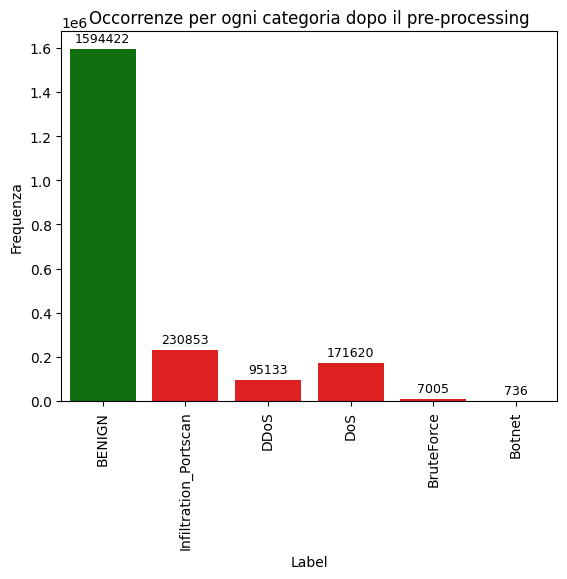

In [ ]:
## traffic type distribution in training set after oversampling
order = ['BENIGN', 'Infiltration_Portscan', 'DoS', 'DDoS', 'BruteForce', 'Botnet']

palette = {}
for key in order:
    palette[key] = "g" if key == "BENIGN" else "r"
# Assuming 'df' is your DataFrame and 'Label' is the column you want to visualize
g = sns.countplot(x='Label', data=df_importance, palette=palette)

# Add count values on top of each bar
for p in g.patches:
    g.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Occorrenze per ogni categoria dopo il pre-processing')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.ylabel('Frequenza')

plt.savefig(f"{images_dir}/distribuzFINALELabelCICIDS2017.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [ ]:
#####sistemo feature categoriche = feature encoding
data_encoded = df_importance.copy()
#cerco quelle numeriche per poi scremare e trovare le categoriche
cols = data_encoded.columns
num_cols = data_encoded._get_numeric_data().columns
print(list(set(cols) - set(num_cols)))

print("======================")
print(data_encoded.shape)

['Label']
(2099769, 72)


In [ ]:
print(data_encoded['Label'].value_counts()) #6 classi finali per la classificazione del traffico

BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
Name: Label, dtype: int64


In [ ]:
#hot-encoding multi-class
## Label

cat_cols = ["Label"]
cat_cols_encoded = []
for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(data_encoded[col].unique())]

cat_cols_encoded

['L_BENIGN',
 'L_Infiltration_Portscan',
 'L_DDoS',
 'L_DoS',
 'L_BruteForce',
 'L_Botnet']

In [ ]:
#NON FUNZIONA con onehotencoder di preprocessing lib (Dà NaN verso la fine)
#USO DUMMIES

df_finEnc = pd.get_dummies(
    data=data_encoded,
    columns=["Label"],
    prefix=["L"])

df_finEnc.head()

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,...,ActiveMax,ActiveMin,IdleMin,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_BruteForce,L_DDoS,L_DoS,L_Infiltration_Portscan
0,61810,53,17,155865,1,1,56,72,56,56,...,0,0,0,0,1,0,0,0,0,0
1,58056,5633,6,69,1,1,0,0,0,0,...,0,0,0,69,0,0,0,0,0,1
2,62117,53,17,106359793,3,3,153,482,64,42,...,762710,30648,8633476,0,1,0,0,0,0,0
3,58278,53,17,61202,2,2,78,142,39,39,...,0,0,0,0,1,0,0,0,0,0
4,58239,443,6,524988,21,17,704,10802,357,0,...,0,0,0,524988,1,0,0,0,0,0


#### Binarizzo IP come encoding - **NO**

In [ ]:
#CIT - https://www.mohammedalani.com/tutorials/handling-ip-addresses-in-machine-learning-datasets/
#not be able to identify the relationship between IP addresses of two hosts within the same network
#BUT
#it can be helpful in recognizing data flows, and doing statistics analysis of data originating or landing in a specific node

## ---------- BINARIZZO IP -------------- #LABEL BINARIZE
train_data = ['127.0.0.1']
df_ipEnc = df_finEnc.copy()
ip_encoder = preprocessing.LabelBinarizer()
print(df_ipEnc["SrcIP"].values[3])
df_ipEnc = ip_encoder.fit_transform(df_ipEnc["SrcIP"].values[3].split('.'))


In [ ]:
print(df_ipEnc)
print("=================")
print(df_ipEnc.tolist())

In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
data_encoded.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

#### Splitting IP come encoding - **NO**

In [ ]:
#Splitting IP for DstIP e SrcIP - CIT: Shao Thesis dice che è meglio splittare in 4 feature l'IP
# split the Name column into 4 columns
df_finEnc[['DstIP_1', 'DstIP_2', 'DstIP_3', 'DstIP_4']] = df_finEnc['DstIP'].str.split('.', expand=True)
df_finEnc[['SrcIP_1', 'SrcIP_2', 'SrcIP_3', 'SrcIP_4']] = df_finEnc['SrcIP'].str.split('.', expand=True)
df_finEnc["DstIP_1"] = df_finEnc["DstIP_1"].apply(int)
df_finEnc["DstIP_2"] = df_finEnc["DstIP_2"].apply(int)
df_finEnc["DstIP_3"] = df_finEnc["DstIP_3"].apply(int)
df_finEnc["DstIP_4"] = df_finEnc["DstIP_4"].apply(int)
df_finEnc["SrcIP_1"] = df_finEnc["SrcIP_1"].apply(int)
df_finEnc["SrcIP_2"] = df_finEnc["SrcIP_2"].apply(int)
df_finEnc["SrcIP_3"] = df_finEnc["SrcIP_3"].apply(int)
df_finEnc["SrcIP_4"] = df_finEnc["SrcIP_4"].apply(int)

#elimino colonne SrcIP, DstIP non più utili
df_finEnc = df_finEnc.drop('SrcIP', axis=1)
df_finEnc = df_finEnc.drop('DstIP', axis=1)

df_finEnc

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalLengthofFwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthStd,...,L_Portscan,L_WebAttacks_Heartbleed,DstIP_1,DstIP_2,DstIP_3,DstIP_4,SrcIP_1,SrcIP_2,SrcIP_3,SrcIP_4
0,57235,53,17,270,2,82,41,41,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
1,50194,53,17,1214161,4,128,32,32,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
2,49476,53,17,1333756,2,74,37,37,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,19
3,37820,80,6,175982,9,296,296,0,98.666667,1547.981999,...,0,0,192,168,10,50,172,16,0,1
4,64579,53,17,283967,2,86,43,43,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065306,60920,53,17,116473,1,49,49,49,0.000000,0.000000,...,0,0,192,168,10,1,192,168,10,3
2065307,52752,80,6,3559942,7,20,20,0,7.559289,4129.722297,...,0,0,192,168,10,50,172,16,0,1
2065308,61611,443,6,2247446,21,910,341,0,88.258333,679.746241,...,0,0,172,217,10,227,192,168,10,8
2065309,59631,53,17,60745,2,68,34,34,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,51


In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
df_finEnc.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

##Feature Normalization

In [ ]:
df_finEnc['FlowDuration'].isin([0]).any()

False

In [ ]:
###Feature normalization
norm_data = df_finEnc.copy()
print(norm_data.shape) #77 feature totali

(2099769, 77)


In [ ]:
norm_data.info()

In [ ]:
#MIN-MAX SCALING NORMALIZATION - eseguito da FEDANIDS e Li et al. (2023)

x = norm_data.values
normMinMax = preprocessing.MinMaxScaler(feature_range=(0,1))
df_minMaxScal = normMinMax.fit_transform(x)
data_ready = pd.DataFrame(df_minMaxScal, columns=norm_data.columns)

data_ready.head()

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,...,ActiveMax,ActiveMin,IdleMin,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_BruteForce,L_DDoS,L_DoS,L_Infiltration_Portscan
0,0.94316014343480580884,0.00080880220970867866,1.00000000000000000000,0.00129886669913833411,0.00000455043934491875,0.00000342557258445749,0.00000435111915446566,0.00000010984780658104,0.00225624496373892040,0.03804347826086956763,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
1,0.88587777523460742302,0.08596194051488655063,0.35294117647058820264,0.00000056666668083333,0.00000455043934491875,0.00000342557258445749,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000227794646608,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000
2,0.94784466315709159367,0.00080880220970867866,1.00000000000000000000,0.88633162215829053299,0.00001365131803475626,0.00001027671775337248,0.00001188787911845083,0.00000073537003850088,0.00257856567284448033,0.02853260869565217225,...,0.00692758766666865238,0.00027837147383417136,0.07194579221362447374,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
3,0.88926527809567401661,0.00080880220970867866,1.00000000000000000000,0.00051000834608354198,0.00000910087868983750,0.00000685114516891498,0.00000606048739372003,0.00000021664428520150,0.00157131345688960511,0.02649456521739130405,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
4,0.88867017624170285828,0.00676036563964046554,0.35294117647058820264,0.00437489177603896107,0.00009555922624329379,0.00005823473393577737,0.00005469978365613976,0.00001648022231511719,0.01438356164383561633,0.00000000000000000000,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00001733180520774302,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000


In [ ]:
#SALVO CSV prima del sampling ...potesse servirmi per cambiare e fare altro
data_ready.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataPreprocessed.csv', index = False)

#SPLITTING
* Creazione dataset piccolo (meno feature) per primi esperimenti GAN + divisione per categoria perché la GAN traina su singole categorie
* Creazione dataset ufficiale con #feature finali per esperimenti finali
* Divisione del dataset: test set, validation set, test set

In [ ]:
dataFin = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataPreprocessed.csv')

####Splitto DS nelle categorie di label

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```



In [ ]:
d_Benign = dataFin[dataFin['L_BENIGN'] == 1]
d_Portscan = dataFin[dataFin['L_Infiltration_Portscan'] == 1]
d_DDoS = dataFin[dataFin['L_DDoS'] == 1]
d_DoS = dataFin[dataFin['L_DoS'] == 1]
d_BruteForce = dataFin[dataFin['L_BruteForce'] == 1]
d_Botnet = dataFin[dataFin['L_Botnet'] == 1]
#SALVO CSV
d_Benign.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Benign.csv', index = False)
d_Portscan.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Portscan.csv', index = False)
d_DDoS.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_DDoS.csv', index = False)
d_DoS.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_DoS.csv', index = False)
d_BruteForce.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_BruteForce.csv', index = False)
d_Botnet.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Botnet.csv', index = False)

### Dataset più piccolo con 20 feature importanti
* su 77 feature tolgo 6 dei label => su 71 feature scelgo le prime 35 più importanti

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
importances[:35].index

Index(['FlowDuration', 'BwdPacketLengthStd', 'PacketLengthVariance', 'DstPort',
       'TotalLengthofFwdPacket', 'PacketLengthStd', 'FlowIATMax',
       'FlowPackets/s', 'FwdPacketLengthMax', 'BwdPacketLengthMax',
       'BwdSegmentSizeAvg', 'RSTFlagCount', 'BwdPacketLengthMean',
       'SubflowFwdBytes', 'PacketLengthMean', 'PacketLengthMax',
       'FwdPackets/s', 'AveragePacketSize', 'FwdSegmentSizeAvg',
       'FwdPacketLengthMean', 'FlowBytes/s', 'SubflowBwdBytes',
       'BwdBulkRateAvg', 'FwdPacketLengthStd', 'TotalLengthofBwdPacket',
       'FwdHeaderLength', 'FlowIATMean', 'BwdHeaderLength', 'FwdRSTFlags',
       'FWDInitWinBytes', 'BwdInitWinBytes', 'FwdIATMax', 'BwdPackets/s',
       'ACKFlagCount', 'FwdSegSizeMin'],
      dtype='object', name='Feature')

In [ ]:
#estraggo solo 35 feature importanti
# Features are all columns except the one-hot encoded 'Label' columns
features = dataFin[['FlowDuration', 'BwdPacketLengthStd', 'PacketLengthVariance', 'DstPort',
       'TotalLengthofFwdPacket', 'PacketLengthStd', 'FlowIATMax',
       'FlowPackets/s', 'FwdPacketLengthMax', 'BwdPacketLengthMax',
       'BwdSegmentSizeAvg', 'RSTFlagCount', 'BwdPacketLengthMean',
       'SubflowFwdBytes', 'PacketLengthMean', 'PacketLengthMax',
       'FwdPackets/s', 'AveragePacketSize', 'FwdSegmentSizeAvg',
       'FwdPacketLengthMean', 'FlowBytes/s', 'SubflowBwdBytes',
       'BwdBulkRateAvg', 'FwdPacketLengthStd', 'TotalLengthofBwdPacket',
       'FwdHeaderLength', 'FlowIATMean', 'BwdHeaderLength', 'FwdRSTFlags',
       'FWDInitWinBytes', 'BwdInitWinBytes', 'FwdIATMax', 'BwdPackets/s',
       'ACKFlagCount', 'FwdSegSizeMin']]

# Target is the one-hot encoded 'Label' columns
target = dataFin[['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']]

#features.head()
#print("==================================================")
#target.head()

In [ ]:
#splitto 80-20 rule
from sklearn.model_selection import train_test_split

#Setting the random state to a fixed number ensures that the split is the same every time you run the code = 3
#TRAIN SET, VALIDATION SET, TEST SET
X_train35, X_temp, y_train35, y_temp = train_test_split(features, target, test_size=0.2, random_state=3)
X_val35, X_test35, y_val35, y_test35 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=3)


### Dataset completo

In [ ]:
features = dataFin.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

target = dataFin[['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']]

#splitto 80-20 rule
#Setting the random state to a fixed number ensures that the split is the same every time you run the code = 42
#TRAIN SET, VALIDATION SET, TEST SET
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=3)

###### Solo un check sulle feature che ha scelto l'altra foresta

In [ ]:
# Assuming 'X_train' and 'y_train' are your training data and labels
# You can replace RandomForestClassifier with any other classifier suitable for your data
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train)

# Use feature importance scores to select the top 35 features
feature_importances = clf.feature_importances_
selected_features = X_train.columns[feature_importances.argsort()[-35:][::-1]]

selected_features

Index(['BwdPacketLengthStd', 'RSTFlagCount', 'PacketLengthStd', 'DstPort',
       'FwdPacketLengthMean', 'TotalLengthofFwdPacket', 'FwdSegmentSizeAvg',
       'FwdPacketLengthMax', 'PacketLengthMax', 'FwdPackets/s',
       'BwdPacketLengthMean', 'AveragePacketSize', 'FlowPackets/s',
       'PacketLengthVariance', 'BwdSegmentSizeAvg', 'SubflowFwdBytes',
       'SubflowBwdBytes', 'PacketLengthMean', 'BwdPacketLengthMax',
       'FlowIATMax', 'FWDInitWinBytes', 'FlowDuration', 'FwdIATTotal',
       'FlowIATMean', 'BwdHeaderLength', 'BwdPackets/s', 'TotalFwdPacket',
       'FwdHeaderLength', 'FwdRSTFlags', 'FwdPacketLengthStd', 'ACKFlagCount',
       'PSHFlagCount', 'TotalBwdpackets', 'TotalTCPFlowTime', 'FwdIATMean'],
      dtype='object')